In [1]:
import numpy as np
import pandas as pd
import requests
import random
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse
import wget
import ast
import json
from PIL import Image, ImageDraw, ImageOps
import ndjson
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

In [2]:
categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
data_filepath = '../datasets'
label_dict = {}

In [3]:
for i in range(0,len(categories)):
    label_dict[i] = categories[i]

Save label dictionary

In [4]:
with open('../service/label_dict.json', 'w') as f:
    json.dump(categories, f)

### Download datasets

In [5]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=data_filepath+'mnist.npz')

In [6]:
def view_images_grid(X, y, label_dict):
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[int(y[r_label])])

    plt.show()

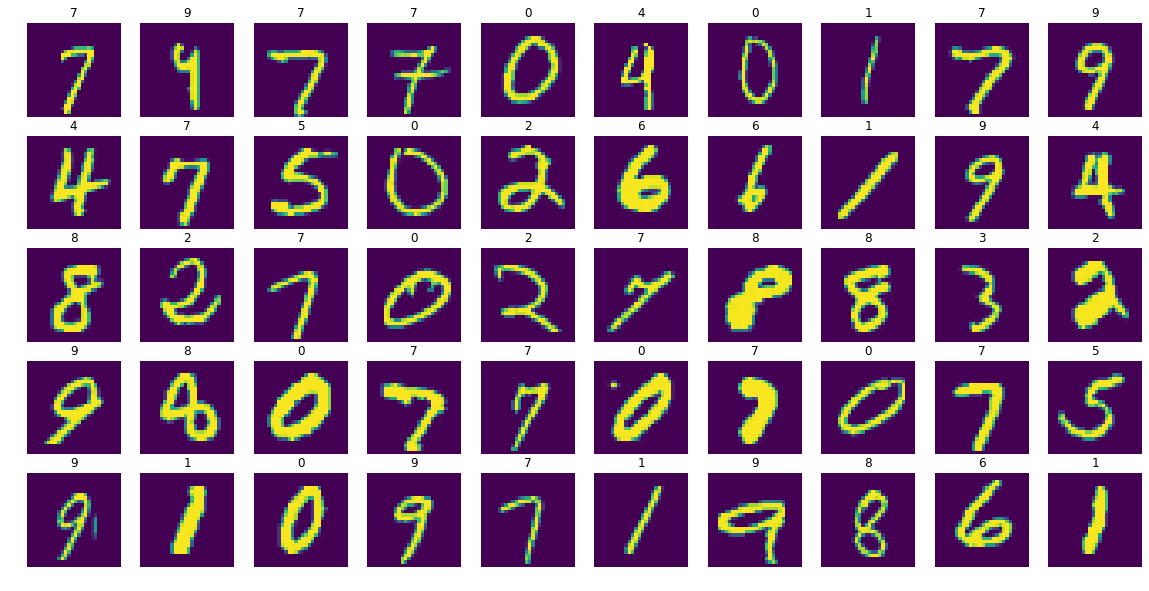

In [7]:
view_images_grid(x, y, label_dict)

In [8]:
x = x.reshape(x.shape[0], 784) / 255
x_test = x_test.reshape(x_test.shape[0], 784) / 255

In [9]:
y = y.astype('float32')
y_test = y_test.astype('float32')

In [10]:
train = torch.from_numpy(x).float()
train_labels = torch.from_numpy(y).long()
test = torch.from_numpy(x_test).float()
test_labels = torch.from_numpy(y_test).long()

In [11]:
train.shape

torch.Size([60000, 784])

In [12]:
train_labels.shape

torch.Size([60000])

### Describe model

In [13]:
def build_model(input_size = 784, output_size = 10, hidden_sizes = [392, 196, 98], dropout = 0.0):
    return nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                            ('bn2', nn.BatchNorm1d(num_features = hidden_sizes[1])),
                            ('relu2', nn.ReLU()),
                            ('dropout', nn.Dropout(dropout)),
                            ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                            ('bn3', nn.BatchNorm1d(num_features = hidden_sizes[2])),
                            ('relu3', nn.ReLU()),
                            ('logits', nn.Linear(hidden_sizes[2], output_size))]))

### Research

In [14]:
def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [15]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0):
    print("Fitting model with epochs = {epochs}, learning rate = {lr}"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [16]:
def get_preds(model, input):
    with torch.no_grad():
        logits = model.forward(input)

    ps = F.softmax(logits, dim=1)
    return ps

In [17]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [18]:
def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {}".format(accuracy_train))
    print("Accuracy score for test set is {}".format(accuracy_test))
    return accuracy_train, accuracy_test

Plot learning curve depending on the number of epochs.

In [19]:
learning_rate = 0.003
weight_decay = 0.0
n_chunks = 1000

In [ ]:
epochs_range = np.arange(10, 150, 10)
train_acc = []
test_acc = []

for epochs in epochs_range:
    model = build_model()
    fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)
    accuracy_train, accuracy_test = evaluate_model(model, train, train_labels, test, test_labels)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

In [ ]:
x = epochs_range
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning rate = ' + str(learning_rate), fontsize=20)
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

### Train turget model

In [20]:
epochs = 100
n_chunks = 1000
learning_rate = 0.0005
weight_decay = 0

In [21]:
input_size = 784
output_size = 10
hidden_sizes = [392, 196, 98]
dropout = 0.0

In [22]:
model = build_model(input_size, output_size, hidden_sizes, dropout)

In [23]:
fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)

Fitting model with epochs = 100, learning rate = 0.0005
Epoch: 1/100  Loss: 0.7728
Epoch: 1/100  Loss: 0.3205
Epoch: 1/100  Loss: 0.2234
Epoch: 1/100  Loss: 0.1772
Epoch: 1/100  Loss: 0.1752
Epoch: 1/100  Loss: 0.1397
Epoch: 1/100  Loss: 0.1387
Epoch: 1/100  Loss: 0.1268
Epoch: 1/100  Loss: 0.1135
Epoch: 1/100  Loss: 0.1193
Epoch: 2/100  Loss: 0.0819
Epoch: 2/100  Loss: 0.0814
Epoch: 2/100  Loss: 0.0885
Epoch: 2/100  Loss: 0.0866
Epoch: 2/100  Loss: 0.0805
Epoch: 2/100  Loss: 0.0733
Epoch: 2/100  Loss: 0.0916
Epoch: 2/100  Loss: 0.0797
Epoch: 2/100  Loss: 0.0721
Epoch: 2/100  Loss: 0.0856
Epoch: 3/100  Loss: 0.0541
Epoch: 3/100  Loss: 0.0564
Epoch: 3/100  Loss: 0.0553
Epoch: 3/100  Loss: 0.0551
Epoch: 3/100  Loss: 0.0561
Epoch: 3/100  Loss: 0.0592
Epoch: 3/100  Loss: 0.0614
Epoch: 3/100  Loss: 0.0528
Epoch: 3/100  Loss: 0.0561
Epoch: 3/100  Loss: 0.0545
Epoch: 4/100  Loss: 0.0337
Epoch: 4/100  Loss: 0.0330
Epoch: 4/100  Loss: 0.0345
Epoch: 4/100  Loss: 0.0452
Epoch: 4/100  Loss: 0.0435

Epoch: 30/100  Loss: 0.0069
Epoch: 30/100  Loss: 0.0030
Epoch: 30/100  Loss: 0.0035
Epoch: 30/100  Loss: 0.0046
Epoch: 30/100  Loss: 0.0045
Epoch: 30/100  Loss: 0.0035
Epoch: 31/100  Loss: 0.0024
Epoch: 31/100  Loss: 0.0061
Epoch: 31/100  Loss: 0.0033
Epoch: 31/100  Loss: 0.0030
Epoch: 31/100  Loss: 0.0031
Epoch: 31/100  Loss: 0.0039
Epoch: 31/100  Loss: 0.0055
Epoch: 31/100  Loss: 0.0047
Epoch: 31/100  Loss: 0.0049
Epoch: 31/100  Loss: 0.0026
Epoch: 32/100  Loss: 0.0031
Epoch: 32/100  Loss: 0.0016
Epoch: 32/100  Loss: 0.0048
Epoch: 32/100  Loss: 0.0056
Epoch: 32/100  Loss: 0.0068
Epoch: 32/100  Loss: 0.0044
Epoch: 32/100  Loss: 0.0037
Epoch: 32/100  Loss: 0.0041
Epoch: 32/100  Loss: 0.0055
Epoch: 32/100  Loss: 0.0043
Epoch: 33/100  Loss: 0.0023
Epoch: 33/100  Loss: 0.0035
Epoch: 33/100  Loss: 0.0067
Epoch: 33/100  Loss: 0.0025
Epoch: 33/100  Loss: 0.0028
Epoch: 33/100  Loss: 0.0028
Epoch: 33/100  Loss: 0.0052
Epoch: 33/100  Loss: 0.0025
Epoch: 33/100  Loss: 0.0029
Epoch: 33/100  Loss:

Epoch: 59/100  Loss: 0.0020
Epoch: 59/100  Loss: 0.0016
Epoch: 59/100  Loss: 0.0005
Epoch: 60/100  Loss: 0.0004
Epoch: 60/100  Loss: 0.0014
Epoch: 60/100  Loss: 0.0011
Epoch: 60/100  Loss: 0.0009
Epoch: 60/100  Loss: 0.0006
Epoch: 60/100  Loss: 0.0020
Epoch: 60/100  Loss: 0.0026
Epoch: 60/100  Loss: 0.0032
Epoch: 60/100  Loss: 0.0042
Epoch: 60/100  Loss: 0.0036
Epoch: 61/100  Loss: 0.0017
Epoch: 61/100  Loss: 0.0021
Epoch: 61/100  Loss: 0.0020
Epoch: 61/100  Loss: 0.0011
Epoch: 61/100  Loss: 0.0017
Epoch: 61/100  Loss: 0.0017
Epoch: 61/100  Loss: 0.0025
Epoch: 61/100  Loss: 0.0017
Epoch: 61/100  Loss: 0.0033
Epoch: 61/100  Loss: 0.0033
Epoch: 62/100  Loss: 0.0011
Epoch: 62/100  Loss: 0.0022
Epoch: 62/100  Loss: 0.0011
Epoch: 62/100  Loss: 0.0025
Epoch: 62/100  Loss: 0.0016
Epoch: 62/100  Loss: 0.0007
Epoch: 62/100  Loss: 0.0023
Epoch: 62/100  Loss: 0.0017
Epoch: 62/100  Loss: 0.0017
Epoch: 62/100  Loss: 0.0007
Epoch: 63/100  Loss: 0.0005
Epoch: 63/100  Loss: 0.0008
Epoch: 63/100  Loss:

Epoch: 89/100  Loss: 0.0055
Epoch: 89/100  Loss: 0.0028
Epoch: 89/100  Loss: 0.0026
Epoch: 89/100  Loss: 0.0021
Epoch: 89/100  Loss: 0.0037
Epoch: 89/100  Loss: 0.0025
Epoch: 89/100  Loss: 0.0034
Epoch: 89/100  Loss: 0.0026
Epoch: 89/100  Loss: 0.0025
Epoch: 89/100  Loss: 0.0015
Epoch: 90/100  Loss: 0.0011
Epoch: 90/100  Loss: 0.0007
Epoch: 90/100  Loss: 0.0002
Epoch: 90/100  Loss: 0.0001
Epoch: 90/100  Loss: 0.0017
Epoch: 90/100  Loss: 0.0018
Epoch: 90/100  Loss: 0.0006
Epoch: 90/100  Loss: 0.0007
Epoch: 90/100  Loss: 0.0004
Epoch: 90/100  Loss: 0.0003
Epoch: 91/100  Loss: 0.0001
Epoch: 91/100  Loss: 0.0002
Epoch: 91/100  Loss: 0.0000
Epoch: 91/100  Loss: 0.0004
Epoch: 91/100  Loss: 0.0017
Epoch: 91/100  Loss: 0.0010
Epoch: 91/100  Loss: 0.0006
Epoch: 91/100  Loss: 0.0022
Epoch: 91/100  Loss: 0.0006
Epoch: 91/100  Loss: 0.0005
Epoch: 92/100  Loss: 0.0013
Epoch: 92/100  Loss: 0.0012
Epoch: 92/100  Loss: 0.0003
Epoch: 92/100  Loss: 0.0005
Epoch: 92/100  Loss: 0.0002
Epoch: 92/100  Loss:

In [24]:
evaluate_model(model, train, train_labels, test, test_labels)

Accuracy score for train set is 0.9998833333333333
Accuracy score for test set is 0.9851


(0.9998833333333333, 0.9851)

In [25]:
filepath = '../service/models/model.nnet'

In [26]:
metainfo = {'input_size': input_size,
            'output_size': output_size,
            'hidden_layers': hidden_sizes,
            'dropout': dropout,
            'state_dict': model.state_dict()}

torch.save(metainfo, filepath)
print("Model saved to {}\n".format(filepath))

Model saved to ../service/models/model.nnet

